## Ipython notebook magic

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload

## Python libraries

In [2]:
import pylab
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import re
import time
import datetime
import pandas as pd
import random
import trackpy as tp
from sklearn.externals import joblib

/home/perlusha/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import trackpy.diag
trackpy.diag.performance_report()

Yes, but could it be faster?
FAST: numba is available and enabled (fast subnets and feature-finding).


## My libraries

In [4]:
sys.path.append('/home/perlusha/Work/2017/2017.05.30-2D_tracking_library_4Roshni/lib/')
import image #contains image/video analysis functions
reload(image)

import traj_proc_2_1 #library for calculating swimming statistics
reload(traj_proc_2_1)

import plot #plots
reload(plot)

<module 'plot' from '/home/perlusha/Work/2017/2017.05.30-2D_tracking_library_4Roshni/lib/plot.pyc'>

# Define local constants

In [5]:
pixsize = 0.26 #size of the image pixel in microns
mnsize = 5 #minimal size of bacteria in pixels
mxsize = 250 #maximal size of bacteria in pixels
imdim = 2048 #size of the image in pixels
fps = 12 #video framerate
max_search_range = 45/(fps*pixsize) #maximum displacement of the bacteria between consequent frames in pixels
min_search_range = 10
min_len = 20 #length cut-off for trajectories in frames

In [6]:
regexps = {'folder': '.+(?=\/)',
          'filename': '(?<=\/)[^\/]+(?=.avi)',
          'date_time': '(?<=_)[0-9, -]+(?=-000)'}
time_format = '%Y-%m-%d-%H%M%S'

In [7]:
suffix_traj = 'traj&params'
suffix_traj_proc = 'runs&tumbles'
suffix_trace = 'trace'

In [8]:
aggregations = {'vel': lambda x: np.nanpercentile(x, 95),
                'vel_angle': np.nanmean,
               'frame': 'count'}
params4filtering = ['vel', 'vel_angle']

## Plotting parameters

In [9]:
seaborn.set_style('white')

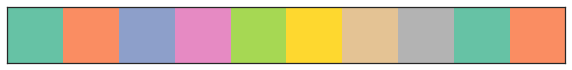

In [10]:
current_palette = seaborn.color_palette("Set2", 10)
seaborn.palplot(current_palette)

## Detecting bacteria and finding trajectories

In [11]:
movie = '../data/fc2_save_2016-11-17-151445-0000.avi'

Get basic information about the movie.

In [12]:
file_info = {}
for key in regexps.keys():
    file_info[key] = re.findall(re.compile(regexps[key]), movie)[0]
file_info['date_time'] = datetime.datetime(*time.strptime(file_info['date_time'], time_format)[:6])
file_info['date_time'] = pd.to_datetime(file_info['date_time'])

In [18]:
file_info

{'date_time': Timestamp('2016-11-17 15:14:45'),
 'filename': 'fc2_save_2016-11-17-151445-0000',
 'folder': '../data'}

First let's find background frame and make sure that default settings make sense. 
Changing alpha will change the weight of each individual frame in the background accumulation procedure and therefore will change brightness of the background frame and affect the number of bacteria detected

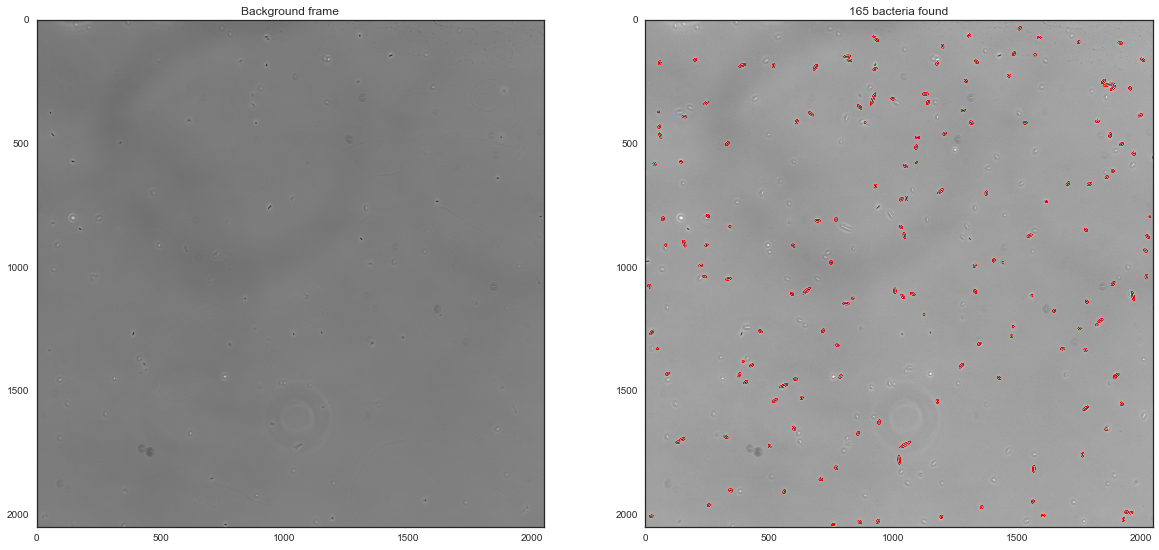

In [17]:
background, frame = image.test_detection(movie, mnsize = mnsize, mxsize = mxsize, alpha = 0.005, show = True)

Now we are going to detect bacteria in every frame of the movie. This function also plots number of bacteria vs frame number for testing purposes.

165  bacteria found in  0 th frame
153  bacteria found in  100 th frame
165  bacteria found in  200 th frame
169  bacteria found in  300 th frame
180  bacteria found in  400 th frame
176  bacteria found in  500 th frame
156  bacteria found in  600 th frame


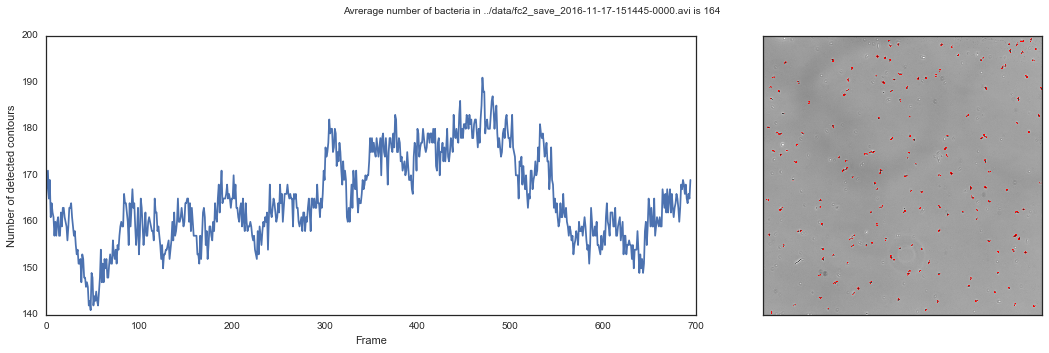

In [18]:
coords, img = image.find_cells_video(movie, background, maxframe = None,  mnsize = mnsize, mxsize = mxsize, write = False)

Coords is a dataframe with coordinates, lengths and angles of every feature found in every frame of the movie. That is the input format for the next stages of analysis - linking, calculating parameters etc, although only 'frame', 'x' and 'y' columns are necessary.

In [21]:
coords.head()

,body_angle,frame,length,x,y
0,45.000004,0,2.443317,759.804016,2038.803955
1,16.113289,0,4.200377,755.904114,2038.351196
2,125.793159,0,8.081859,864.404297,2027.721558
3,39.486984,0,6.985452,937.933472,2025.272705
4,17.921721,0,7.493322,1925.906250,2017.018677


Coordinates are linked into trajectories using linking function from TrackPy library.

In [22]:
traj = tp.link_df(coords, search_range = max_search_range, adaptive_stop = min_search_range, adaptive_step=0.98, memory = 1)

Frame 694: 169 trajectories present


In addition to headers from 'coords' dataframe output of linking contains particle #.

In [25]:
traj.head()

,body_angle,frame,length,x,y,particle
0,45.000004,0,2.443317,759.804016,2038.803955,0.0
1,45.000004,1,2.443317,759.804016,2038.803955,0.0
2,45.000004,2,2.443317,759.804016,2038.803955,0.0
3,45.000004,3,2.443317,759.804016,2038.803955,0.0
4,45.000000,4,3.188964,760.000000,2039.000000,0.0


Now let's calculate parameters of the trajectories. In addition to coordinates we now have velocities and accelerations.

In [26]:
traj_proc_2_1.calc_params(traj, wind = 1, fps = fps, pix_size = pixsize)

/home/perlusha/Work/2017/2017.05.30-2D_tracking_library_4Roshni/lib/traj_proc_2_1.py:135: RuntimeWarning: divide by zero encountered in divide
  diff = diff/(traj['frame'].values[wind:] - traj['frame'].values[:-wind])
/home/perlusha/Work/2017/2017.05.30-2D_tracking_library_4Roshni/lib/traj_proc_2_1.py:137: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  diff[idx_edge] = np.nan
/home/perlusha/Work/2017/2017.05.30-2D_tracking_library_4Roshni/lib/traj_proc_2_1.py:135: RuntimeWarning: invalid value encountered in divide
  diff = diff/(traj['frame'].values[wind:] - traj['frame'].values[:-wind])


In [29]:
traj.loc[:, 'date_time'] = file_info['date_time']
traj.head()

,body_angle,frame,length,x,y,particle,index,vel,acc,angle,vel_angle,acc_angle,date_time
0,45.000004,0,2.443317,759.804016,2038.803955,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2016-11-17 15:14:45
1,45.000004,1,2.443317,759.804016,2038.803955,0.0,1,0.000000,0.000000,0.000000,0.000000,113.119755,2016-11-17 15:14:45
2,45.000004,2,2.443317,759.804016,2038.803955,0.0,2,0.000000,10.378601,0.000000,9.426646,NaN,2016-11-17 15:14:45
3,45.000004,3,2.443317,759.804016,2038.803955,0.0,3,0.864883,NaN,0.785554,NaN,NaN,2016-11-17 15:14:45
4,45.000000,4,3.188964,760.000000,2039.000000,0.0,4,NaN,NaN,NaN,NaN,NaN,2016-11-17 15:14:45


Save processed file and add it to the file database.

In [30]:
file_info['filename_traj'] = '{0}/{1}_{2}.csv'.format(file_info['folder'], file_info['filename'], suffix_traj)
traj.to_csv(file_info['filename_traj'])

## Filtering

For further analysis all trajectories shorter than 20 frames should be removed so before doing that let's look at the distribution of trajectory lengths.

/home/perlusha/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


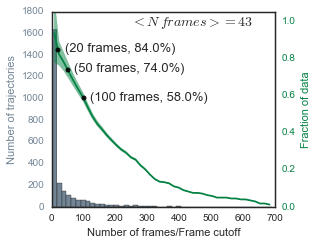

In [31]:
plot.traj_len_dist(traj, bw = 15, cutoffs = [20, 50, 100])

Remove trajectories shorter than min_len. Needs to be set to at least 20 for tumble bias assignment.

In [32]:
traj = tp.filter_stubs(traj, min_len)

For each trajectory calculate statistics according to 'aggregations'. Essentially for each trajectories we calculate a set of numbers that are later used for filtering.

In [33]:
traj_stats = traj.groupby([u'particle'], as_index = False).agg(aggregations)

In [34]:
traj_stats.head()

,particle,vel,vel_angle,frame
0,3.0,23.770902,1.694313,78
1,6.0,5.613804,19.079964,695
2,7.0,25.549626,2.233874,30
3,9.0,7.709409,11.574632,69
4,13.0,19.373405,2.112204,393


Find KDE, MADs and center of the main cluster in the new parameter space of trajectories.

In [44]:
(x0, y0), (MADx, MADy), (Z, extent) = traj_proc_2_1.find_MADs_KDE(traj_stats[params4filtering[0]], traj_stats[params4filtering[1]])
distances = traj_proc_2_1.assign_dist(traj_stats, params = params4filtering, center = (x0, y0), R = (MADx, MADy))
layers = np.arange(max(distances), stop = 2, step = -2)
layers.sort()


In [45]:
traj_stats.head()

,particle,vel,vel_angle,frame,distance
0,3.0,23.770902,1.694313,78,2.0
1,6.0,5.613804,19.079964,695,8.0
2,7.0,25.549626,2.233874,30,2.0
3,9.0,7.709409,11.574632,69,6.0
4,13.0,19.373405,2.112204,393,2.0


Plot resulsing KDE along with ellipses corresponding to certain distance from the center and example trajectories in each layer.

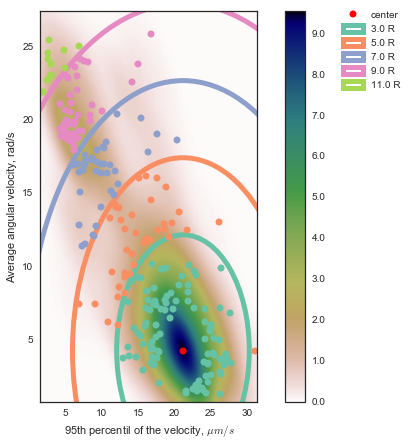

In [46]:
plot.plot_KDE(Z, extent, N_traj = len(traj_stats), tick_step = 1)
plot.plot_ellipses(plt.gca(), (MADx, MADy), (x0, y0), layers, colors = current_palette)
plt.plot(x0, y0, 'o', color = 'Red', markersize = 7, label = 'center')
i = 0
traj2plot = []
for layer in np.sort(layers):

    particles = traj_stats[(traj_stats.distance <= layer)&(traj_stats.distance > layer - 2)&(traj_stats.frame > 50)].particle   
    particles = random.sample(particles, min(100, len(particles)))
    plt.plot(traj_stats[traj_stats.particle.isin(particles)].vel, 
             traj_stats[traj_stats.particle.isin(particles)].vel_angle, 'o', color = current_palette[i],
            label = '')
    traj2plot.append({'layer': layer, 'particles': particles})
    i += 1
plt.xlabel(r'95th percentil of the velocity, $\mu m/s$')
plt.ylabel(r'Average angular velocity, rad/s')
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.9))
plt.gca().set_aspect(1.8*np.diff(plt.gca().get_xlim())[0]/np.diff(plt.gca().get_ylim())[0])

Now plot trajectories from each layer.

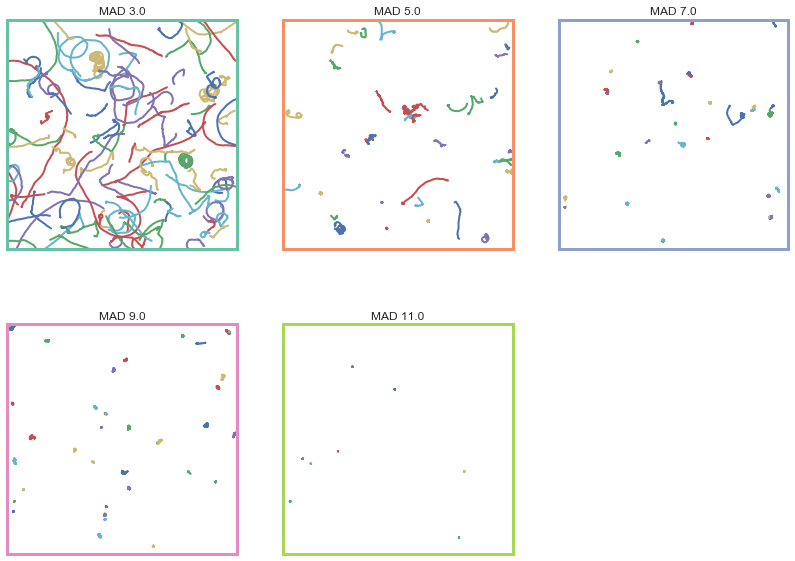

In [47]:
i = 0
plt.figure(figsize=(14, 10))

for i in range(len(traj2plot)):
    particles = traj2plot[i]['particles']
    plt.subplot(2,3,i+1)
    plot.plot_traj(traj[traj.particle.isin(particles)].reset_index(drop = True), imdim)
    plt.title('MAD {0}'.format(traj2plot[i]['layer']))
    plt.gca().set_aspect(1.0)
    for spine in plt.gca().spines.values():
        spine.set_edgecolor(current_palette[i])
        spine.set_linewidth(3)

Remove trajectories further than certain distance away from the center.

In [48]:
particles_filt = traj_stats[traj_stats.distance <= 3].particle.unique()
traj_filtered = traj[traj.particle.isin(particles_filt)].copy(deep = True)

## Run-tumble assignment

Load model for run-tumble detection. You can use trained model or train it on the current dataset as well.

In [49]:
HMM_model = joblib.load('../lib/HMM_model_10:29.pkl')

Assign runs and tumbles.

iteration  0
iteration 

/home/perlusha/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/perlusha/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


 1
iteration  2


/home/perlusha/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


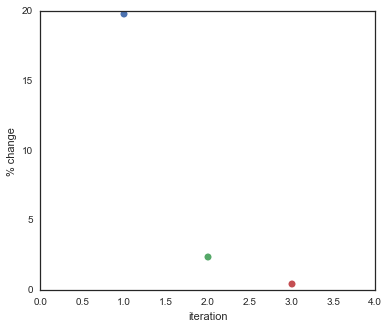

In [50]:
traj_filtered = traj_filtered[~np.isnan(traj_filtered.acc_angle)]
traj_filtered.sort_values(by = ['particle', 'frame'], inplace=True)

_, traj_filtered = traj_proc_2_1.find_tumbles(traj_filtered,
                    model = HMM_model,
                    params = ['vel_norm', 'acc_norm', 'acc_angle'], 
                    n_components = 3, 
                    threshold = 1,
                    covariance_type = 'diag',
                    model_type = 'HMM')

Plot resulting distribution of parameters in run and tumble states.

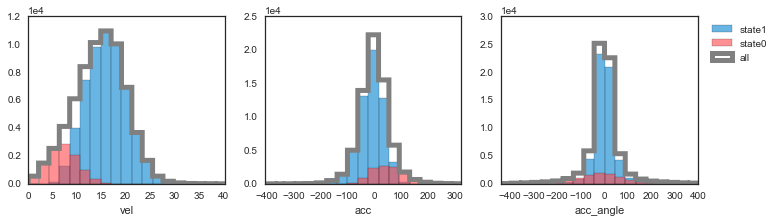

In [51]:
colors = ['light red', 'cerulean']
palette = seaborn.xkcd_palette(colors)
plot.dist_by_state(traj_filtered, 'tbias_HMM', ('vel', 'acc', 'acc_angle'), palette = palette)


Save analyzed trajectories to file.

In [52]:
file_info['filename_proc'] = '{0}/{1}_{2}.csv'.format(file_info['folder'], file_info['filename'], suffix_traj_proc)
traj_filtered.to_csv(file_info['filename_proc'])

## Time trace

Calculate and save time traces.

In [54]:
traj2save = tp.filter_stubs(tracks = traj_filtered, threshold = 50)
trace =  traj2save.groupby(['frame', 'date_time'], 
                            as_index = False)[['vel_angle', 'vel_run', 
                                               'tbias_HMM', 'vel']].agg(['mean', 'std', 'count'])
trace.reset_index(inplace = True)

file_info['filename_trace'] = '{0}/{1}_{2}.csv'.format(file_info['folder'], file_info['filename'], suffix_trace)
trace.to_csv(file_info['filename_trace'])

Plot time traces

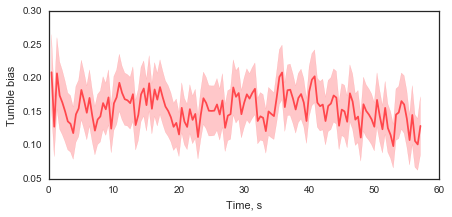

In [57]:
f, ax = plt.subplots(1, 1, figsize = (7, 3), sharex=True)

_ = plot.plot_trace(ax, wind = 5, shift = 5, data = trace[['frame', 'tbias_HMM']], fps = fps, 
           color = palette[0], tbias = True)
plt.xlabel('Time, s')
plt.ylabel('Tumble bias')